In [1]:
# import event simulation files
import sys
sys.path.insert(0, '../../DataGeneration')
import GenEvents as ge
import PlotEvents as pe
import EventData as ed
import Params as ps

In [2]:
import numpy as np
import tqdm 
import math
import matplotlib.pyplot as plt
import csv

import torch
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchmetrics.classification import BinaryConfusionMatrix

import snntorch as snn
from snntorch import spikegen
import snntorch.spikeplot as splt
from snntorch import surrogate
import snntorch.functional as SF

from sklearn.metrics import ConfusionMatrixDisplay

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
n_evt_val = 10000

evt_arr_val,  muon_list_val,  max_n_val  = ge.generate_noisy_evts(n_evt_val,  noise_frac=0.5, bkg_frac=0.3)

100%|██████████| 10000/10000 [00:12<00:00, 787.60it/s]


In [4]:
# transform each event (muon_hits list) to np.array of fixed size
def convert_to(muon_list, size, target_dtype, features):
    padded_array = np.zeros(shape=(len(muon_list), size, len(features)), dtype=target_dtype)
    for i, muon_hits in enumerate(muon_list):
        for j, hit in enumerate(muon_hits):
            for k, f in enumerate(features):
                padded_array[i,j,k] = hit[f]  # BEWARE: implicit type conversions going on here

    return torch.tensor(padded_array)

feature_list = ['layer', 'wire_num', 'bx', 't0', 'signal']
mu_arr_val  = convert_to(muon_list_val,  size=max_n_val,  target_dtype=np.float32, features=feature_list)

In [5]:
def custom_spikegen(data, num_step=40, batch_size=100, linearise=True):

    spike_data = torch.zeros(size=(num_step, batch_size, ps.NLAYERS,ps.NWIRES), dtype=data.dtype)
    for n_batch, evt in enumerate(data):
        for hit in evt:
            layer = int(hit[0])
            wire = int(hit[1])
            bx = int(hit[2])
            t0 = math.floor(hit[3])
            if bx != 0:
                spike_data[bx-t0+ps.bx_oot, n_batch, layer-1, wire-1] = 1
            else:
                break
    if linearise:
        spike_data = spike_data.view(num_step, batch_size, -1)
                
    return spike_data   

In [6]:
def gen_target_cell(muon_list, linearise=True):
    target = np.zeros(shape=(len(muon_list), ps.NLAYERS, ps.NWIRES))
    for i, evt in tqdm.tqdm(enumerate(muon_list)):
        for hit in evt:
            layer, wire = hit['layer']-1, hit['wire_num']-1

            if hit['signal'] == True:
                target[i, layer, wire] = 1
    target = torch.tensor(target, dtype=torch.long)
    if linearise:
        target = target.view(len(muon_list), -1)

    return target

In [7]:
class CustomDataset(Dataset):
    def __init__(self, input_data, target, transform=None):
        self.data = list(zip(input_data, target))
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        sample = self.data[idx]
        
        if self.transform:
            sample = self.transform(sample)
            
        return sample


# Transformations

# converts to Torch tensor of desired type
def to_tensor_and_dtype(input_variable, target_dtype=torch.float32):
    
    # Convert to PyTorch tensor
    if type(input_variable) != torch.Tensor:
        input_variable = torch.tensor(input_variable)
    # Force the tensor to have the specified dtype
    tensor = input_variable.to(target_dtype)
    
    return tensor


transform = transforms.Compose([
    lambda x: (to_tensor_and_dtype(x[0], target_dtype=torch.float32), x[1])
])

In [8]:
target_val  = gen_target_cell(muon_list_val)

val_dataset   = CustomDataset(mu_arr_val,  target_val,  transform=transform)

batch_size = 100
nw=0

val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=nw)

10000it [00:00, 248627.96it/s]


In [9]:
class Net_LIF_1L(nn.Module):
    """FCN with 1 hidden layer and LIF neurons."""

    def __init__(self, input_feat, hidden, out_feat, timesteps,
                 learnable, beta=0.8, threshold=1.0):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = out_feat              # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network

        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                learn_beta=learnable, learn_threshold=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Leaky(beta=beta, spike_grad=spike_grad, threshold=threshold,
                                 learn_beta=learnable, learn_threshold=learnable)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        mem1 = self.lif_in.init_leaky()
        mem2 = self.lif_out.init_leaky()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
                
            cur1 = self.fc_in(x[step])
            spk1, mem1 = self.lif_in(cur1, mem1)
            cur2 = self.fc_out(spk1)
            spk2, mem2 = self.lif_out(cur2, mem2)
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [10]:
class Net_Syn_1L(nn.Module):
    """FCN with 1 hidden layer and Synaptic neurons."""

    def __init__(self, input_feat, hidden, out_feat, timesteps,
                 learnable, beta=0.8, threshold=1.0, alpha=0.8):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = out_feat              # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network
        
        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden)
        self.lif_in = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                   spike_grad=spike_grad,
                                   learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden, out_features=self.out_feat)
        self.lif_out = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                    spike_grad=spike_grad,
                                    learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
    
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        syn1, mem1 = self.lif_in.init_synaptic()
        syn2, mem2 = self.lif_out.init_synaptic()

        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
            cur1 = self.fc_in(x[step])
            spk1, syn1, mem1 = self.lif_in(cur1, syn1, mem1)
            
            cur2 = self.fc_out(spk1)
            spk2, syn2, mem2 = self.lif_out(cur2, syn2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [11]:
class Net_Syn_3L(nn.Module):
    """FCN with 3 hidden layers and Synaptic neurons."""

    def __init__(self, input_feat, hidden, out_feat, timesteps,
                 learnable, beta=0.8, threshold=1.0, alpha=0.8):
        super().__init__()
        
        self.input_feat = input_feat          # number of input neurons 
        self.hidden = hidden                  # number of hidden neurons
        self.out_feat = out_feat              # number of output neurons
        
        self.timesteps = timesteps            # number of time steps to simulate the network

        spike_grad = surrogate.fast_sigmoid() # surrogate gradient function
        
        self.fc_in = nn.Linear(in_features=self.input_feat, out_features=self.hidden[0])
        self.lif_in = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                   spike_grad=spike_grad,
                                   learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
        
        self.fc_hidden1 = nn.Linear(in_features=self.hidden[0], out_features=self.hidden[1])
        self.lif_hidden1 = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                        spike_grad=spike_grad,
                                        learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
        
        self.fc_hidden2 = nn.Linear(in_features=self.hidden[1], out_features=self.hidden[2])
        self.lif_hidden2 = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                        spike_grad=spike_grad,
                                        learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
        
        self.fc_out = nn.Linear(in_features=self.hidden[2], out_features=self.out_feat)
        self.lif_out = snn.Synaptic(beta=beta, alpha=alpha, threshold=threshold,
                                    spike_grad=spike_grad,
                                    learn_beta=learnable, learn_threshold=learnable, learn_alpha=learnable)
        
    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        syn1, mem1 = self.lif_in.init_synaptic()
        synh1, memh1 = self.lif_hidden1.init_synaptic()
        synh2, memh2 = self.lif_hidden2.init_synaptic()
        syn2, mem2 = self.lif_out.init_synaptic()
        
        # Record the final layer
        spk2_rec = []
        mem2_rec = []

        # Loop over 
        for step in range(self.timesteps):
            cur1 = self.fc_in(x[step])
            spk1, syn1, mem1 = self.lif_in(cur1, syn1, mem1)
            
            curh1 = self.fc_hidden1(spk1)
            spkh1, synh1, memh1 = self.lif_hidden1(curh1, synh1, memh1)
            
            curh2 = self.fc_hidden2(spkh1)
            spkh2, synh2, memh2 = self.lif_hidden2(curh2, synh2, memh2)
            
            cur2 = self.fc_out(spkh2)
            spk2, syn2, mem2 = self.lif_out(cur2, syn2, mem2)
            
            spk2_rec.append(spk2)
            mem2_rec.append(mem2)

        return torch.stack(spk2_rec, dim=0), torch.stack(mem2_rec, dim=0)

In [12]:
class Multi_loss(nn.Module):
    def __init__(self, n_classes, loss_func, timing):
        super(Multi_loss, self).__init__()
        self.n_classes = n_classes
        self.loss = loss_func
        self.timing = timing

    def forward(self, inputs, targets):
        loss = 0
        for i in range(inputs.shape[-1]//self.n_classes):
            if self.timing:
                loss += self.loss(inputs[:, :, i*self.n_classes:(i+1)*self.n_classes],
                                  targets[:, :, i])
            else:
                loss += self.loss(inputs[:, :, i*self.n_classes:(i+1)*self.n_classes],
                                  targets[:, i])
        return loss

In [13]:
def comp_accuracy(output, targets, type):
    total = 0
    correct = 0
    predicted = None

    # whole chamber classification
    if type == 'chamber':
        _, predicted = output.sum(dim=0).max(1)
        total = targets.size(0)
        correct = (predicted == targets).sum().item()

    # cell-by-cell classification
    elif type == 'cell':
        batch_size = targets.size(0)
        _, predicted = output.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1).max(2)
        total = targets.numel()
        correct = (predicted == targets).sum().item()

    # accuracy on the whole event for cell-by-cell classification
    elif type == 'cell_per_evt':
        batch_size = targets.size(0)
        total = batch_size
        _, predicted = output.sum(dim=0).view(batch_size, ps.NLAYERS*ps.NWIRES, -1).max(2)
        for i in range(batch_size):
            correct += torch.sum((predicted[i] == targets[i]).all())

    # accuracy cell-by-cell moment-by-moment for precise timing recontruction
    # (MSE loss)
    elif type == 'mse_timing':
        total = targets.numel()
        correct = (output == targets).sum().item()
        predicted = output

    # accuracy on the whole event for timing reconstruction
    # (MSE loss)
    elif type == 'mse_timing_per_evt':
        batch_size = targets.size(1)
        total = batch_size
        for i in range(batch_size):
            correct += torch.sum((output[:, i] == targets[:, i]).all())
        predicted = output

    # accuracy cell-by-cell moment-by-moment for precise timing recontruction
    # (CEMRL)
    elif type == "ce_timing":
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        total = targets.numel()
        _, predicted = output.view(num_steps, batch_size, ps.NLAYERS*ps.NWIRES, -1).max(3)
        correct = (predicted == targets).sum().item()

    # accuracy on the whole event for timing reconstruction
    # (CEMRL)
    elif type == "ce_timing_per_evt":
        num_steps = targets.size(0)
        batch_size = targets.size(1)
        total = batch_size
        _, predicted = output.view(num_steps, batch_size, ps.NLAYERS*ps.NWIRES, -1).max(3)
        for i in range(batch_size):
            correct += torch.sum((predicted[:, i] == targets[:, i]).all())

    # accuracy cell-by-cell moment-by-moment for precise timing recontruction
    # (BCEMRL)
    elif type == "bce_timing":
        total = targets.numel()
        sigmoid = nn.Sigmoid()
        predicted = sigmoid(output)
        predicted[predicted <  0.5] = 0
        predicted[predicted >= 0.5] = 1
        correct = (predicted == targets).sum().item()

    # accuracy on the whole event for timing reconstruction
    # (BCEMRL)
    elif type == "bce_timing_per_evt":
        batch_size = targets.size(1)
        total = batch_size
        sigmoid = nn.Sigmoid()
        predicted = sigmoid(output)
        predicted[predicted <  0.5] = 0
        predicted[predicted >= 0.5] = 1
        for i in range(batch_size):
            correct += torch.sum((predicted[:, i] == targets[:, i]).all())
   

    return total, correct, predicted

In [14]:
def accuracy_set(net, data_loader, loss_fn, accuracy_type, num_steps,
                 batch_size, CM, timing, linearise, use_membrane):
    bcm = BinaryConfusionMatrix()
    net.eval()
    with torch.no_grad():
        total = 0
        correct = 0
        temp_loss = []
        cm = torch.tensor([[0,0],[0,0]])
        for data, targets in data_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data, num_steps, batch_size, linearise)
            spike_in = spike_in.to(device)
            if timing:
                targets = custom_spikegen(targets, num_steps, batch_size, linearise).type(torch.long)

            # forward pass
            spk_rec, mem_rec = net(spike_in)
            output = None
            if use_membrane:
                output = mem_rec
            else:
                output = spk_rec

            # compute loss
            loss = loss_fn(output, targets)
            temp_loss.append(loss.item())

            # calculate total accuracy
            tot, corr, pred = comp_accuracy(output, targets, accuracy_type)
            total += tot
            correct += corr
            if CM:
                cm += bcm(pred, targets)

        mean_loss = np.mean(temp_loss)
        acc = correct/total
        if CM:
            cm = cm/cm.sum()

        return mean_loss, acc, cm

In [15]:
def F1_score(cm):
    TP = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    precision = TP/(TP + FP)
    recall = TP/(TP + FN)

    f1 = 2*precision*recall/(precision+recall)
    if math.isnan(f1):
        f1 = 0

    return f1

In [16]:
def train_net(net, train_loader, val_loader, num_epochs, loss_fn, optimizer, accuracy_type,
              num_steps, batch_size, linearise=True, timing=False, use_membrane=False):

    net.to(device)
    
    loss_hist = []
    loss_val_hist = []
    acc_val_hist = []

    iter_counter = 0

    # Validation
    mean_loss_val, acc_val, _ = accuracy_set(net, val_loader, loss_fn, accuracy_type, num_steps,
                                             batch_size, False, timing, linearise, use_membrane)

    loss_val_hist.append(mean_loss_val)
    acc_val_hist.append(acc_val)
    print(f"Validation Set Loss: {mean_loss_val}")
    print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
    print("\n--------------------------------------------------\n")

    for epoch in range(num_epochs):
        net.train()
        batch_counter = 0
        # Minibatch training loop
        for data, targets in train_loader:
            data = data.to(device)
            targets = targets.to(device)

            # create spike train
            spike_in = custom_spikegen(data, num_steps, batch_size, linearise)
            spike_in = spike_in.to(device)
            if timing:
                targets = custom_spikegen(targets, num_steps, batch_size, linearise).type(torch.long)

            # forward pass
            spk_rec, mem_rec = net(spike_in)
            output = None
            if use_membrane:
                output = mem_rec
            else:
                output = spk_rec

            # compute loss
            loss_val = loss_fn(output, targets)
        
            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()

            # Store loss history for future plotting
            loss_hist.append(loss_val.item())
        
            if iter_counter % 50 == 0:
                print("Epoch:", epoch+1)
                print("Batch:", batch_counter)
                print("Iteration:", iter_counter)
                print("Loss:", loss_val.item(),"\n")
        
            batch_counter += 1
            iter_counter += 1

        # Validation
        mean_loss_val, acc_val, _ = accuracy_set(net, val_loader, loss_fn, accuracy_type, num_steps,
                                                 batch_size, False, timing, linearise, use_membrane)

        loss_val_hist.append(mean_loss_val)
        acc_val_hist.append(acc_val)
        print(f"Validation Set Loss: {mean_loss_val}")
        print(f"Validation Set Accuracy: {100 *acc_val:.2f}%")
        print("\n--------------------------------------------------\n")

    return loss_hist, loss_val_hist, acc_val_hist

## Test Accuracy

In [17]:
num_inputs  = ps.NLAYERS*ps.NWIRES
num_outputs = 2*num_inputs
num_steps   = 40

num_epochs = 10
accuracy_type = 'cell'
loss_fn = Multi_loss(2, SF.ce_count_loss(), False)

In [18]:
# Network Architecture 1
num_hidden1 = 100
learn1      = False
beta1       = 0.8
threshold1  = 0.9

net1 = Net_LIF_1L(num_inputs, num_hidden1, num_outputs, num_steps,
                  learn1, beta1, threshold1).to(device)

In [19]:
# Network Architecture 2
num_hidden2 = [20,20,20]
learn2      = False
beta2       = 0.8
threshold2  = 0.9
alpha2      = 0.8

net2 = Net_Syn_3L(num_inputs, num_hidden2, num_outputs, num_steps,
                  learn2, beta2, threshold2, alpha2).to(device)

In [20]:
# Network Architecture 3
num_hidden3 = 30
learn3      = False
beta3       = 0.8
threshold3  = 0.9

net3 = Net_LIF_1L(num_inputs, num_hidden3, num_outputs, num_steps,
                  learn3, beta3, threshold3).to(device)

In [21]:
# Network Architecture 4
num_hidden4 = 100
learn4      = False
beta4       = 0.5
threshold4  = 0.9

net4 = Net_LIF_1L(num_inputs, num_hidden4, num_outputs, num_steps,
                  learn4, beta4, threshold4).to(device)

In [22]:
# Network Architecture 5
num_hidden5 = 100
learn5      = False
beta5       = 0.8
threshold5  = 0.9
alpha5      = 0.8

net5 = Net_Syn_1L(num_inputs, num_hidden5, num_outputs, num_steps,
                  learn5, beta5, threshold5).to(device)

In [23]:
# Network Architecture 6
num_hidden6 = 30
learn6      = False
beta6       = 0.5
threshold6  = 0.9

net6 = Net_Syn_1L(num_inputs, num_hidden6, num_outputs, num_steps,
                  learn6, beta6, threshold6).to(device)

In [24]:
# Network Architecture 7
learn7 = True

net7 = Net_LIF_1L(num_inputs, num_hidden1, num_outputs, num_steps,
                  learn7, beta1, threshold1).to(device)

In [25]:
# Network Architecture 8
learn8 = True

net8 = Net_Syn_3L(num_inputs, num_hidden2, num_outputs, num_steps,
                  learn8, beta2, threshold2, alpha2).to(device)

In [26]:
# Network Architecture 9
learn9 = True

net9 = Net_LIF_1L(num_inputs, num_hidden3, num_outputs, num_steps,
                  learn9, beta3, threshold3).to(device)

In [27]:
# Network Architecture 10
learn10 = True

net10 = Net_LIF_1L(num_inputs, num_hidden4, num_outputs, num_steps,
                   learn10, beta4, threshold4).to(device)

In [28]:
# Network Architecture 11
learn11 = True

net11 = Net_Syn_1L(num_inputs, num_hidden5, num_outputs, num_steps,
                   learn11, beta5, threshold5).to(device)

In [29]:
# Network Architecture 12
learn12 = True

net12 = Net_Syn_1L(num_inputs, num_hidden6, num_outputs, num_steps,
                   learn12, beta6, threshold6).to(device)

In [30]:
mean_loss = []
acc =  []
cm = []
f1 = []

for i in range(1,13):
    net_name = f'results/nets_2ndTask/Architecture/net_{i}'
    
    net = globals().get(f'net{i}')
    net.load_state_dict(torch.load(net_name))
    net.eval()

    l, a, c = accuracy_set(net, val_loader, loss_fn, accuracy_type, num_steps,
                           batch_size, True, False, True, True)
    mean_loss.append(l)
    acc.append(a)
    cm.append(c)
    f1.append(F1_score(c))


In [31]:
best_loss = np.argsort(mean_loss)        

print(f'Results after {num_epochs} epochs:\n')
for ind, index in enumerate(best_loss):
    loss_value = mean_loss[index]
    
    print(f'Position {ind+1}: net{index+1} - loss = {round(loss_value,3)}')

Results after 10 epochs:

Position 1: net12 - loss = 5.372
Position 2: net4 - loss = 5.906
Position 3: net3 - loss = 6.388
Position 4: net1 - loss = 6.899
Position 5: net6 - loss = 7.987
Position 6: net10 - loss = 8.555
Position 7: net11 - loss = 8.972
Position 8: net5 - loss = 10.13
Position 9: net9 - loss = 12.23
Position 10: net7 - loss = 13.124
Position 11: net8 - loss = 37.735
Position 12: net2 - loss = 217.558


In [35]:
best_acc = np.argsort(acc) [::-1]       

print(f'Results after {num_epochs} epochs:\n')
for ind,index in enumerate(best_acc):
    acc_value = acc[index]
    
    print(f'Position {ind+1}: net{index+1} - accuracy = {round(acc_value*100,3)}%')

Results after 10 epochs:

Position 1: net10 - accuracy = 96.264%
Position 2: net1 - accuracy = 95.842%
Position 3: net5 - accuracy = 95.823%
Position 4: net4 - accuracy = 95.788%
Position 5: net3 - accuracy = 95.097%
Position 6: net7 - accuracy = 94.936%
Position 7: net11 - accuracy = 94.904%
Position 8: net9 - accuracy = 93.174%
Position 9: net12 - accuracy = 93.036%
Position 10: net6 - accuracy = 92.788%
Position 11: net8 - accuracy = 83.504%
Position 12: net2 - accuracy = 75.174%


Results after 10 epochs:

Position 1: net10 - F1 = 0.894
Position 2: net1 - F1 = 0.884
Position 3: net4 - F1 = 0.882
Position 4: net5 - F1 = 0.882
Position 5: net3 - F1 = 0.864
Position 6: net7 - F1 = 0.862
Position 7: net11 - F1 = 0.839
Position 8: net9 - F1 = 0.823
Position 9: net12 - F1 = 0.763
Position 10: net6 - F1 = 0.733
Position 11: net8 - F1 = 0.506
Position 12: net2 - F1 = 0.409


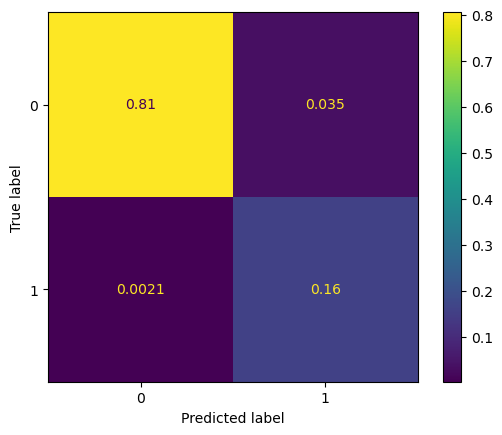

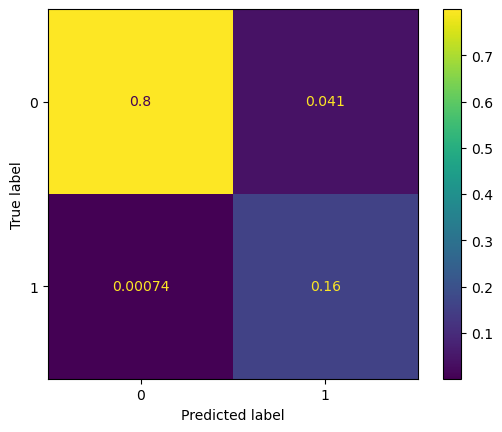

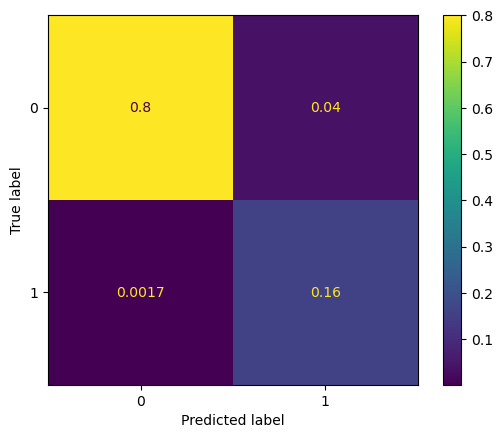

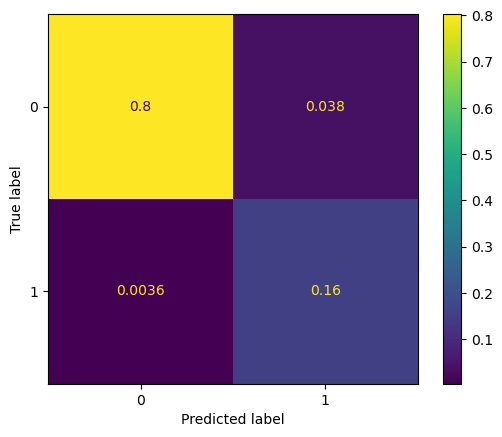

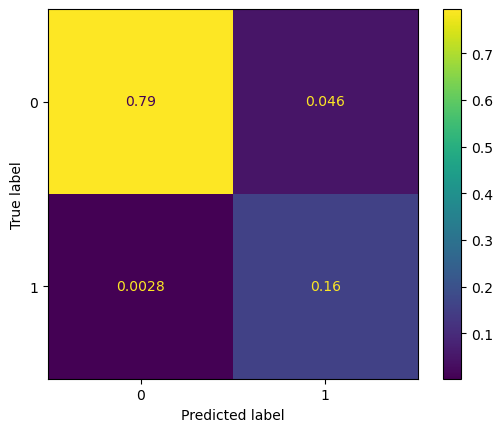

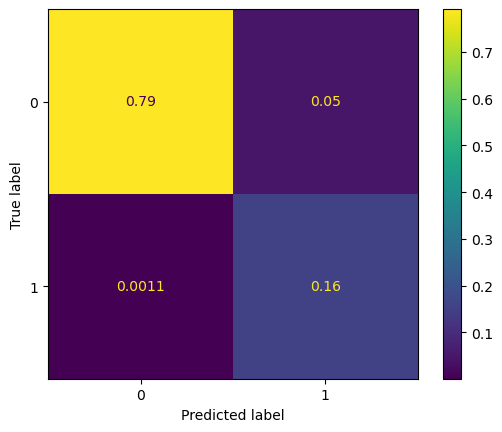

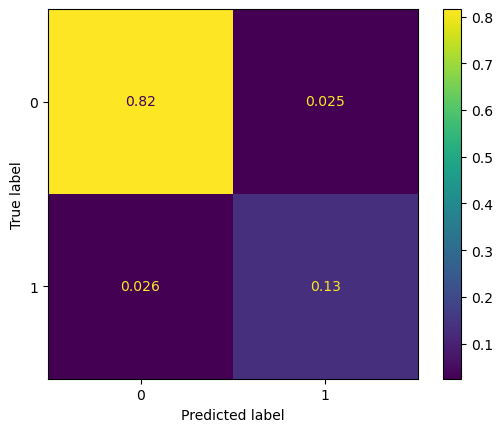

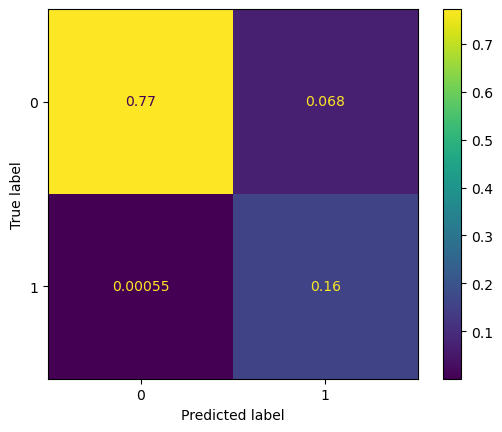

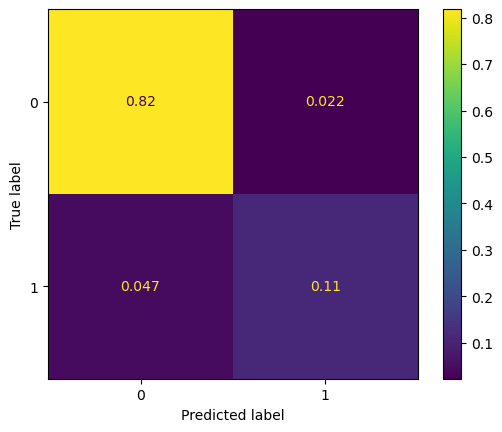

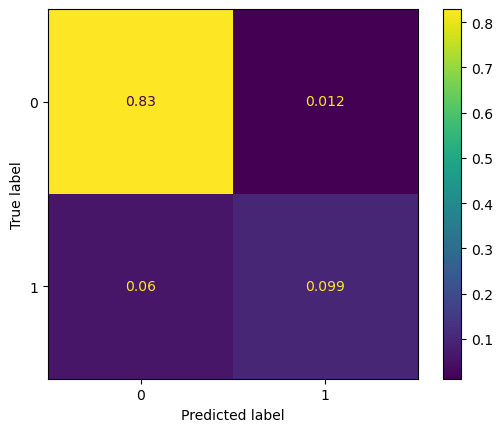

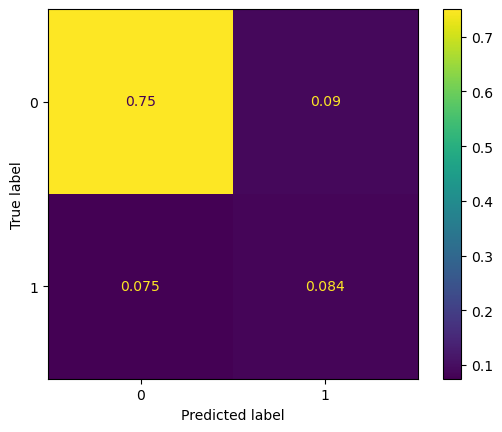

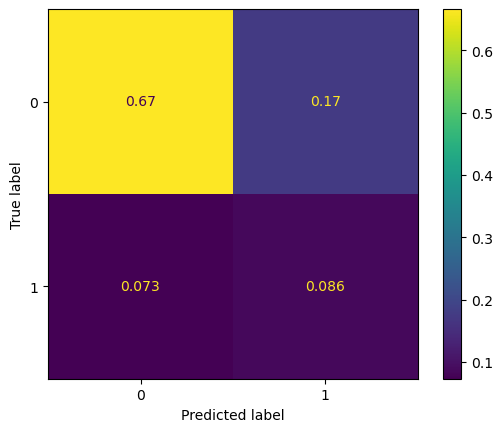

In [44]:
best_f1 = np.argsort(f1)[::-1]     

print(f'Results after {num_epochs} epochs:\n')
for ind, index in enumerate(best_f1):
    f1_value = f1[index].item()
    
    print(f'Position {ind+1}: net{index+1} - F1 = {round(f1_value,3)}')

for ind, index in enumerate(best_f1):
    ConfusionMatrixDisplay(confusion_matrix=cm[index].numpy()).plot()